
# Global optimization of an MGA low-thrust trajectory
The example demonstrates the use of the sims-flanagan module of pykep to perform global optimization of a multiple leg interplanetary trajectory over large launch windows. In particular, it defines a transfer between Earth and Mercury making use of a Venus intermediate fy-by as an global optimization problem and it then attempts to find one solution using the Monotonic Basin Hopping meta-algorithm connected to an SQP local optimization technique.

This solution technique (MBH + SQP) was developed by members of the pykep team and the original publication can be found here:

Yam, C. H., D. D. Lorenzo, and D. Izzo. "Low-thrust trajectory design as a constrained global optimization problem." Proceedings of the Institution of Mechanical Engineers, Part G: Journal of Aerospace Engineering 225, no. 11 (2011): 1243-1251.

A., Cassioli, D. Izzo, Di Lorenzo, D., Locatelli, M. and Schoen, F.: "Global optimization approaches for optimal trajectory planning." In Modeling and optimization in space engineering, pp. 111-140. Springer, New York, NY, 2012.


In [1]:
# Imports
import pykep as pk
import pygmo as pg
import pygmo_plugins_nonfree as ppnf
import numpy as np
from pykep.examples import add_gradient

# Plotting imports
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


In [2]:
# We define the optimization problem udp (User Defined Problem): an Earth-Venus-Mercury transfer with low-thrust
udp = pk.trajopt.mga_lt_nep(
     seq = [pk.planet.jpl_lp('earth'), pk.planet.jpl_lp('venus'), pk.planet.jpl_lp('mercury')],
     n_seg = [5, 20],
     t0 = [3000, 4000], # This is in mjd2000
     tof = [[100, 1000], [200, 2000]], # This is in days
     vinf_dep = 3., # This is in km/s
     vinf_arr = 2., # This is in km/s
     mass = [1000., 2000.0],
     Tmax = 0.5,
     Isp = 3500.0,
     fb_rel_vel = 6., # This is in km/s
     multi_objective = False,
     high_fidelity = False
)
prob = pg.problem(udp)
prob.c_tol = 1e-4
print(prob)

Problem name: <class 'pykep.trajopt._mga_lt_nep.mga_lt_nep'>
	Global dimension:			92
	Integer dimension:			0
	Fitness dimension:			44
	Number of objectives:			1
	Equality constraints dimension:		15
	Inequality constraints dimension:	28
	Tolerances on constraints: [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, ... ]
	Lower bounds: [3000, 100, 1000, -3000, -3000, ... ]
	Upper bounds: [4000, 1000, 2000, 3000, 3000, ... ]
	Has batch fitness evaluation: false

	Has gradient: false
	User implemented gradient sparsity: false
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 0

	Thread safety: none



In [3]:
# We define the optimization algorithm uda (User Defined Algorithm). In this case we use SNOPT from the 
# module pgmo_plugins_nonfree. Note that we point to the snopt7_c library in our system. 
# In such a library is not available, nlopt sqlsqp can also be used here ....
uda = ppnf.snopt7(screen_output = False, library = "/usr/local/lib/libsnopt72_c.so", minor_version = 2) 
uda.set_integer_option("Major iterations limit", 1000)
uda.set_integer_option("Iterations limit", 200000)
uda.set_numeric_option("Major optimality tolerance", 1e-2)
uda.set_numeric_option("Major feasibility tolerance", 1e-8)
uda2 = pg.mbh(uda, 2, 0.05)
algo = pg.algorithm(uda2)
algo.set_verbosity(1)

# We create a population of 100 random initial guesses
pop = pg.population(prob, 100)

In [4]:
pop = algo.evolve(pop)
print(pop.champion_x)

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


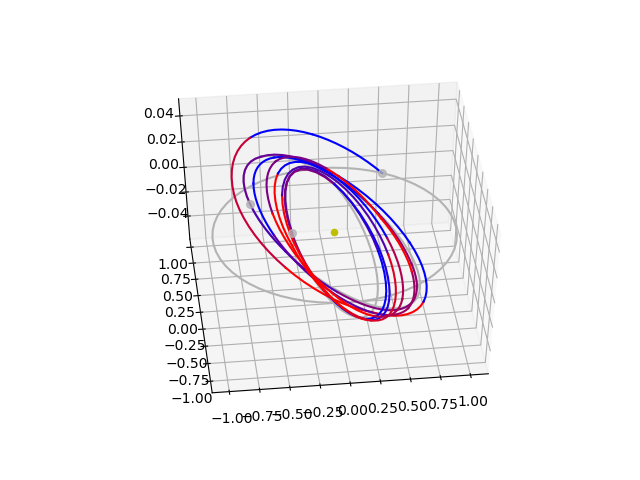

In [4]:
%matplotlib notebook
udp.plot([ 3.24724672e+03,  3.57001751e+02,  1.80696105e+03,  1.16063316e+03,
       -1.77660337e+03,  1.52006215e+03,  6.00000000e+00, -6.00000000e+00,
       -6.00000000e+00,  8.68450194e+02,  1.28131253e+03, -6.00000000e+00,
        6.00000000e+00, -6.00000000e+00,  9.54736007e+02, -1.69205780e+03,
        4.74783924e+02, -6.43082669e-05, -2.90266001e-05,  3.75070545e-05,
       -1.54511630e-01,  7.40733394e-01,  1.91380239e-01, -9.67776846e-01,
       -1.15792218e-01, -1.44004073e-01, -1.29464867e-05, -1.18453940e-04,
        8.69747810e-05,  2.03660623e-01,  3.47426882e-01,  9.43337836e-02,
       -2.07373960e-01,  1.86230842e-01, -9.19278575e-02, -4.52762597e-01,
       -2.42486728e-01,  5.53706806e-02,  1.17876769e-01, -5.11506702e-01,
        2.14613743e-01,  3.63149038e-03,  2.57152913e-04, -4.53813501e-04,
        4.39225339e-04,  1.40474195e-02, -5.06292551e-03, -3.41566520e-01,
        6.52411690e-02, -6.22711834e-02, -3.05754001e-01, -5.06909853e-01,
        1.61067444e-01,  7.07701197e-01, -6.41565690e-01,  2.95894918e-01,
        2.71855640e-01,  3.82516135e-01, -9.21185178e-02, -9.23560506e-01,
        3.51820262e-01, -1.52544369e-01, -1.94827069e-01, -6.34815908e-01,
        1.97141180e-01,  2.01625776e-02, -5.88949163e-05,  1.66748863e-03,
       -6.18696988e-01,  7.50830227e-01, -2.31239353e-01, -4.92606949e-01,
       -6.80940472e-01,  1.71207774e-01,  3.17059599e-01,  1.32715486e-02,
        1.13587959e-02, -8.78424627e-01,  4.36810602e-01, -1.46247394e-01,
        6.73666283e-03, -1.03300714e-01,  2.67917022e-02, -1.48253771e-02,
        4.92059254e-01, -1.16995630e-01, -1.71282823e-03, -2.08940059e-03,
        7.90829404e-04,  2.20150886e-01,  1.44585259e-01, -2.50293811e-02])

In [17]:
pop.champion_x

array([ 3.24724672e+03,  3.57001751e+02,  1.80696105e+03,  1.16063316e+03,
       -1.77660337e+03,  1.52006215e+03,  6.00000000e+00, -6.00000000e+00,
       -6.00000000e+00,  8.68450194e+02,  1.28131253e+03, -6.00000000e+00,
        6.00000000e+00, -6.00000000e+00,  9.54736007e+02, -1.69205780e+03,
        4.74783924e+02, -6.43082669e-05, -2.90266001e-05,  3.75070545e-05,
       -1.54511630e-01,  7.40733394e-01,  1.91380239e-01, -9.67776846e-01,
       -1.15792218e-01, -1.44004073e-01, -1.29464867e-05, -1.18453940e-04,
        8.69747810e-05,  2.03660623e-01,  3.47426882e-01,  9.43337836e-02,
       -2.07373960e-01,  1.86230842e-01, -9.19278575e-02, -4.52762597e-01,
       -2.42486728e-01,  5.53706806e-02,  1.17876769e-01, -5.11506702e-01,
        2.14613743e-01,  3.63149038e-03,  2.57152913e-04, -4.53813501e-04,
        4.39225339e-04,  1.40474195e-02, -5.06292551e-03, -3.41566520e-01,
        6.52411690e-02, -6.22711834e-02, -3.05754001e-01, -5.06909853e-01,
        1.61067444e-01,  